## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
from scipy.signal import stft
import setuptools.dist
import tensorflow as tf;
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from scipy.signal import stft
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

## Nahrání signálu

In [2]:
class Instrument:
    def __init__(self, name, directory) -> None:
        self.name = name
        self.directory = directory
        self.wav_files = [file for file in os.listdir(directory) if file.endswith('.wav')]
        self.signals_raw = {}
        self.signals_envelope = {}
        self.signals_spectogram = {}
        self._load_signals()

    def _load_signals(self):
        for wav_file in self.wav_files:
            file_path = os.path.join(self.directory, wav_file)
            sample_rate, data = wavfile.read(file_path)
            self.signals_raw[wav_file] = (sample_rate, data)
    

all_instrument_classes = []

all_instrument_classes.append(Instrument("cello", "Dataset\\cel"))
all_instrument_classes.append(Instrument("clarinet", "Dataset\\cla"))
all_instrument_classes.append(Instrument("flute", "Dataset\\flu"))
all_instrument_classes.append(Instrument("guitar_acoustic", "Dataset\\gac"))
all_instrument_classes.append(Instrument("guitar_electric", "Dataset\\gel"))
all_instrument_classes.append(Instrument("organ", "Dataset\\org"))
all_instrument_classes.append(Instrument("piano", "Dataset\\pia"))
all_instrument_classes.append(Instrument("saxophone", "Dataset\\sax"))
all_instrument_classes.append(Instrument("trumpet", "Dataset\\tru"))
all_instrument_classes.append(Instrument("violin", "Dataset\\vio"))
all_instrument_classes.append(Instrument("voice", "Dataset\\voi"))

In [8]:
all_instrument_classes[0].signals_raw[a[0]ll_instrument_classeswav_files[0]].shape

TypeError: unhashable type: 'numpy.ndarray'

## Očištění a sjednocení signálu

### Sjednocení
Všechna trénovací data mají stejný sample_rate(44100) i délku(3s) i data_shape(132299, 2), takže není třeba sjednocovat.
Trénovací data jsou stereo, takže kanály musím převézt na mono (zprůměruju kanály, na spektogramech jde vidět že to velkou změnu ve tvaru neudělá).

### Očištění
Audio je kvalitní a žádné závažné problémy, které by bylo třeba odstranit

## Amplitude envelope

In [4]:
# RMS (Root Mean Square) Envelope, because i found it is best for continuous sounds (instruments)
def amplitude_envelope(signal, sample_rate, window_size=0.05):
    window_size_in_samples = int(window_size * sample_rate)
    envelope = []
    for i in range(0, len(signal), window_size_in_samples):
        window = signal[i:i + window_size_in_samples]
        rms = np.sqrt(np.mean(window**2)) if len(window) > 0 else 0
        envelope.append(rms)
    return np.array(envelope)


for instrument in all_instrument_classes:
    for wav_file, (sample_rate, signal) in instrument.signals_raw.items():
        instrument.signals_envelope[wav_file] = amplitude_envelope(signal, sample_rate)

C:\Users\josef\AppData\Local\Temp\ipykernel_1408\1640000231.py:7: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(np.mean(window**2)) if len(window) > 0 else 0


## Spectrogram

In [3]:
# spectrogram se počítá skrz sFT (frekvence místo amplitudy, neural network mňamuje)
'''
Přes librosu to nejde, divný dependencies na starší verze numpy + mel spectogram vzdávám, blbne to
'''

def create_spectrogram(signal, sample_rate, nperseg=1024):
    # If stereo convert to mono by averaging channels
    if len(signal.shape) == 2:
        signal = np.mean(signal, axis=1)
    frequencies, times, spectrogram = stft(signal, fs=sample_rate, nperseg=nperseg)
    return np.abs(spectrogram)

for instrument in all_instrument_classes:
    for wav_file, (sample_rate, signal) in instrument.signals_raw.items():
        print("doing it for ", wav_file)
        instrument.signals_spectogram[wav_file] = create_spectrogram(signal, sample_rate)
        

doing it for  008__[cel][nod][cla]0058__1.wav
doing it for  008__[cel][nod][cla]0058__2.wav
doing it for  008__[cel][nod][cla]0058__3.wav
doing it for  012__[cel][nod][cla]0043__1.wav
doing it for  012__[cel][nod][cla]0043__2.wav
doing it for  012__[cel][nod][cla]0043__3.wav
doing it for  013__[cel][nod][cla]0025__1.wav
doing it for  013__[cel][nod][cla]0025__2.wav
doing it for  013__[cel][nod][cla]0025__3.wav
doing it for  014__[cel][nod][cla]0041__1.wav
doing it for  014__[cel][nod][cla]0041__2.wav
doing it for  014__[cel][nod][cla]0041__3.wav
doing it for  027__[cel][nod][cla]0027__1.wav
doing it for  027__[cel][nod][cla]0027__2.wav
doing it for  027__[cel][nod][cla]0027__3.wav
doing it for  031__[cel][nod][cla]0020__1.wav
doing it for  031__[cel][nod][cla]0020__2.wav
doing it for  031__[cel][nod][cla]0020__3.wav
doing it for  032__[cel][nod][cla]0033__1.wav
doing it for  032__[cel][nod][cla]0033__2.wav
doing it for  032__[cel][nod][cla]0033__3.wav
doing it for  033__[cel][nod][cla]

Plotting spectrogram for: 008__[cel][nod][cla]0058__1.wav


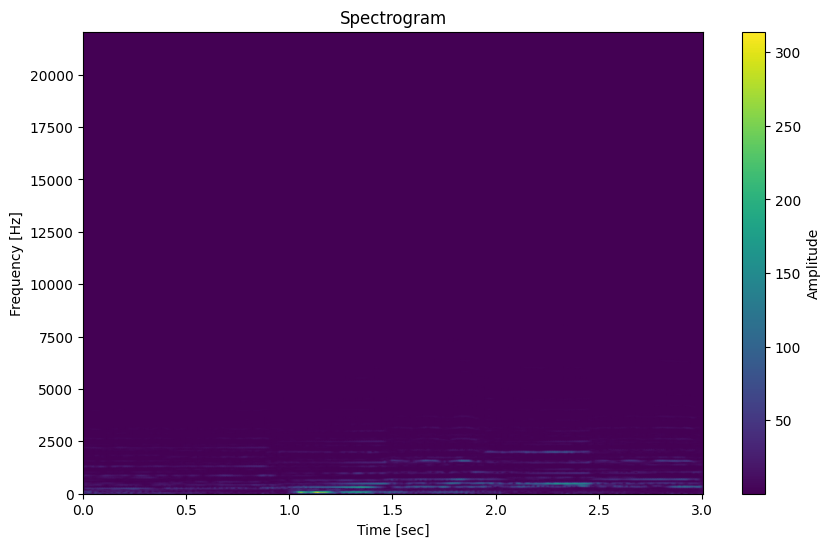

Plotting spectrogram for: 032__[cel][nod][cla]0033__3.wav


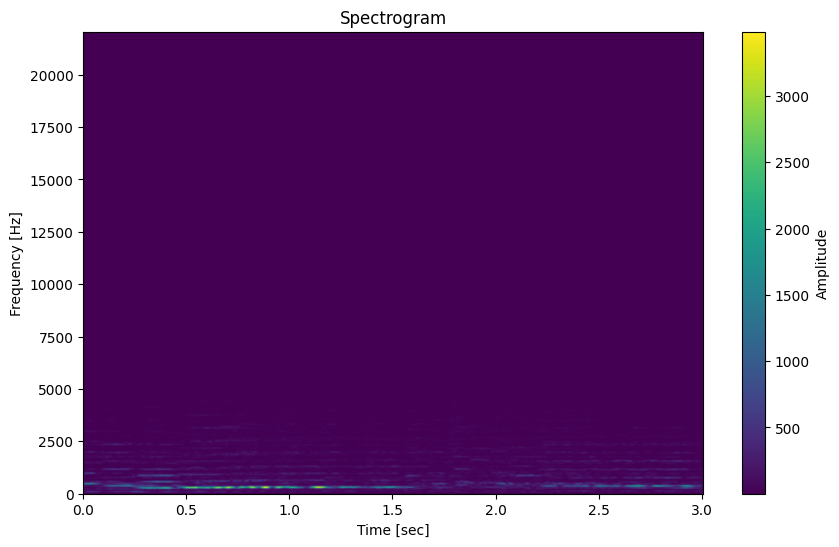

Plotting spectrogram for: 001__[tru][nod][jaz_blu]1986__1.wav


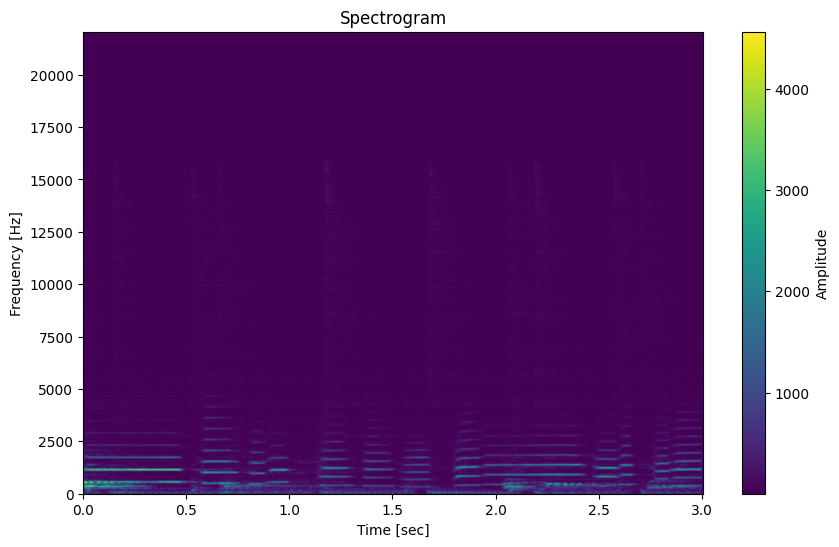

In [4]:
def create_spectrogram(signal, sample_rate, nperseg=1024):
    if len(signal.shape) == 2:
        signal = np.mean(signal, axis=1)
    frequencies, times, spectrogram = stft(signal, fs=sample_rate, nperseg=nperseg)
    return frequencies, times, np.abs(spectrogram)

def plot_spectrogram(frequencies, times, spectrogram):
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, spectrogram, shading='gouraud')
    plt.title('Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Amplitude')
    plt.show()

# Normální cello
first_instrument = all_instrument_classes[0]
wav_files = list(first_instrument.signals_raw.items())[:1]
for wav_file, (sample_rate, signal) in wav_files:
    print("Plotting spectrogram for:", wav_file)
    frequencies, times, spectrogram = create_spectrogram(signal, sample_rate)
    plot_spectrogram(frequencies, times, spectrogram)

# Elektrický cello
first_instrument = all_instrument_classes[0]
wav_files = list(first_instrument.signals_raw.items())[20:21]
for wav_file, (sample_rate, signal) in wav_files:
    print("Plotting spectrogram for:", wav_file)
    frequencies, times, spectrogram = create_spectrogram(signal, sample_rate)
    plot_spectrogram(frequencies, times, spectrogram)

# Trumpeta
first_instrument = all_instrument_classes[8]
wav_files = list(first_instrument.signals_raw.items())[:1]
for wav_file, (sample_rate, signal) in wav_files:
    print("Plotting spectrogram for:", wav_file)
# min max a    frequencies, times, spectrogram = create_spectrogram(signal, sample_rate)
    plot_spectrogram(frequencies, times, spectrogram)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
Xx = []
yy = []

label_dict = {instrument.name: idx for idx, instrument in enumerate(all_instrument_classes)} 

# For each instrument class and signal, compute spectrogram statistics
for instrument in all_instrument_classes:
    for (sample_rate, spectrogram) in instrument.signals_spectogram.items():
        min_values = np.min(spectrogram, axis=1)  # Min for each frequency bin
        max_values = np.max(spectrogram, axis=1)  # Max for each frequency bin
        avg_values = np.mean(spectrogram, axis=1)  # Average for each frequency bin
        features = np.concatenate([min_values, max_values, avg_values])
        Xx.append(features)
        yy.append(label_dict[instrument.name])

In [23]:
Xx = np.array(Xx)
yy = np.array(yy)
Xx_train, Xx_test, yy_train, yy_test = train_test_split(Xx, yy, test_size=0.2, random_state=42)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Xx_train, yy_train)
y_pred = clf.predict(Xx_test)
accuracy = accuracy_score(yy_test, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

Random Forest Accuracy: 57.79%


## Neural network


In [5]:
X = []  # Store spectrograms
y = []  # Store labels

label_dict = {instrument.name: idx for idx, instrument in enumerate(all_instrument_classes)}  # Assign numeric labels

for instrument in all_instrument_classes:
    for (sample_rate, signal) in instrument.signals_spectogram.items():
   #    print(sample_rate)
   #    print(signal)
        X.append(signal)
        y.append(label_dict[instrument.name])

X = np.array(X)
y = np.array(y)

In [7]:
print(X.shape)

(6705, 513, 260)


In [6]:
max_freq = max([spec.shape[0] for spec in X])
max_time = max([spec.shape[1] for spec in X])

# Zero-pad all spectrograms to the same size (max_freq x max_time)
X_padded = np.array([np.pad(spec, ((0, max_freq - spec.shape[0]), (0, max_time - spec.shape[1])), mode='constant') for spec in X])

# Add channel dimension for CNN (e.g., grayscale images)
X_padded = X_padded[..., np.newaxis]

# Normalize data
X_padded = X_padded / np.max(X_padded)

# Convert labels to one-hot encoding
y_onehot = to_categorical(y, num_classes=len(all_instrument_classes))

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_onehot, test_size=0.2, random_state=42)

In [9]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(max_freq, max_time, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 2D matrix to a 1D vector for fully connected layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Output layer: number of classes (instrument types)
model.add(Dense(len(all_instrument_classes), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\josef\Documents\GitHub\USU-IRMAS-instrument-recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 511, 258, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 129, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 63, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 61, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 238080)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,474,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,568,459 (116.61 MB)

 Trainable params: 30,568,459 (116.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train,   
                    validation_data=(X_test, y_test), 
                    epochs=30, 
                    batch_size=32, 
                    callbacks=[reduce_lr])

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.2342 - loss: 2.1852 - val_accuracy: 0.3855 - val_loss: 1.8394 - learning_rate: 0.0010
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 140s 835ms/step - accuracy: 0.4291 - loss: 1.7344 - val_accuracy: 0.4430 - val_loss: 1.6489 - learning_rate: 0.0010
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 137s 817ms/step - accuracy: 0.5671 - loss: 1.3350 - val_accuracy: 0.5108 - val_loss: 1.5721 - learning_rate: 0.0010
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.7014 - loss: 0.9288 - val_accuracy: 0.4877 - val_loss: 1.8713 - learning_rate: 0.0010
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 148s 881ms/step - accuracy: 0.8188 - loss: 0.5746 - val_accuracy: 0.5160 - val_loss: 1.9836 - learning_rate: 0.0010
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 148s 882ms/step - accuracy: 0.8983 - loss: 0.3499 - val_accuracy: 0.5116 - val_loss: 2.5907 - learning_rate: 0.0010
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 147s 875ms/step - accuracy: 0.

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.5391 - loss: 6.6186
Test accuracy: 0.517524242401123


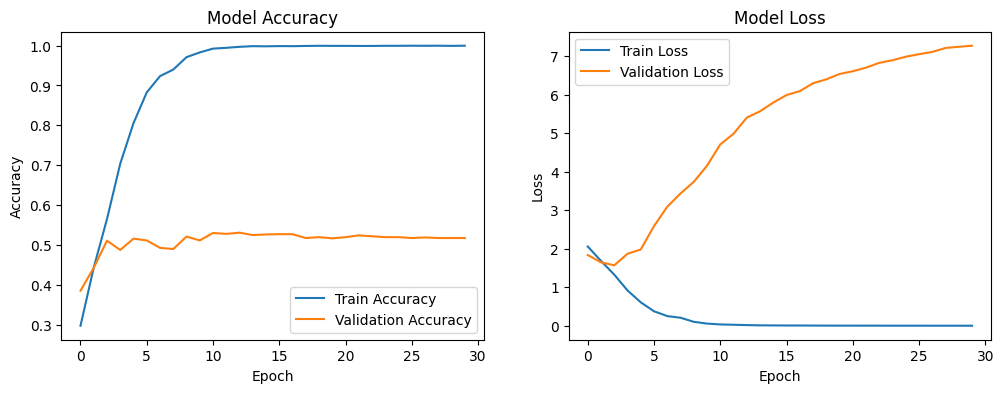

In [24]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
'''

clarinet = tf.data.Dataset.list_files(os.path.join("Dataset", "cla", '*.wav'))
flute = tf.data.Dataset.list_files(os.path.join("Dataset", "flu", '*.wav'))
guitar_acoustic = tf.data.Dataset.list_files(os.path.join("Dataset", "gac", '*.wav'))
guitar_electric = tf.data.Dataset.list_files(os.path.join("Dataset", "gel", '*.wav'))
organ = tf.data.Dataset.list_files(os.path.join("Dataset", "org", '*.wav'))
piano = tf.data.Dataset.list_files(os.path.join("Dataset", "pia", '*.wav'))
saxophone = tf.data.Dataset.list_files(os.path.join("Dataset", "sax", '*.wav'))
trumpet = tf.data.Dataset.list_files(os.path.join("Dataset", "tru", '*.wav'))
violin = tf.data.Dataset.list_files(os.path.join("Dataset", "vio", '*.wav'))
voice = tf.data.Dataset.list_files(os.path.join("Dataset", "voi", '*.wav'))
'''

def parse_file(filename):
    # Define your custom parsing function
    audio = tf.io.read_file(filename)
    audio, _ = tf.audio.decode_wav(audio)
    return audio


file_paths = os.listdir(os.path.join("Dataset", "cel"))
cello_dataset = tf.data.Dataset.from_tensor_slices(file_paths)
cello = cello_dataset.map(parse_file)
cello_labeled = tf.data.Dataset.zip((cello, "cello"))

file_paths = os.listdir(os.path.join("Dataset", "cla"))
clarinet_dataset = tf.data.Dataset.from_tensor_slices(file_paths)
#clarinet = clarinet_dataset.map(parse_file, 1)

file_paths = os.listdir(os.path.join("Dataset", "flu"))
flute_dataset = tf.data.Dataset.from_tensor_slices(file_paths)
#flute = flute_dataset.map(parse_file, 2)



'''
clarinet = clarinet.map(map_string_to_int)
flute = flute.map(map_string_to_int)
guitar_acoustic = guitar_acoustic.map(map_string_to_int)
guitar_electric = guitar_electric.map(map_string_to_int)
organ = organ.map(map_string_to_int)
piano = piano.map(map_string_to_int)
saxophone = saxophone.map(map_string_to_int)
trumpet = trumpet.map(map_string_to_int)
violin = violin.map(map_string_to_int)
voice = voice.map(map_string_to_int)

# Concatenate all the datasets into one
all_instruments = cello.concatenate(clarinet)
all_instruments = all_instruments.concatenate(flute)
all_instruments = all_instruments.concatenate(guitar_acoustic)
'''

'\nclarinet = clarinet.map(map_string_to_int)\nflute = flute.map(map_string_to_int)\nguitar_acoustic = guitar_acoustic.map(map_string_to_int)\nguitar_electric = guitar_electric.map(map_string_to_int)\norgan = organ.map(map_string_to_int)\npiano = piano.map(map_string_to_int)\nsaxophone = saxophone.map(map_string_to_int)\ntrumpet = trumpet.map(map_string_to_int)\nviolin = violin.map(map_string_to_int)\nvoice = voice.map(map_string_to_int)\n\n# Concatenate all the datasets into one\nall_instruments = cello.concatenate(clarinet)\nall_instruments = all_instruments.concatenate(flute)\nall_instruments = all_instruments.concatenate(guitar_acoustic)\n'

In [3]:
import tensorflow as tf
import os

# Define the path to the dataset folder
dataset_path = 'Dataset'

# Get a list of all the instrument folders
instrument_folders = os.listdir(dataset_path)

# Create a dictionary to map instrument names to indices
instrument_indices = {instrument: index for index, instrument in enumerate(instrument_folders)}

# Define a function to load a single WAV file and extract its spectrogram
def load_wav_file(file_path):
    # Load the WAV file
    audio, sample_rate = tf.audio.decode_wav(tf.io.read_file(file_path))
    
    # Extract the spectrogram
    spectrogram = tf.signal.stft(audio, frame_length=256, frame_step=128, fft_length=256)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    # Get the instrument name from the file path
    instrument_name = os.path.basename(os.path.dirname(file_path))
    instrument_index = instrument_indices[instrument_name]
    
    # Return the spectrogram and instrument index
    return spectrogram, instrument_index

# Create a TensorFlow dataset from the WAV files
dataset = tf.data.Dataset.from_tensor_slices([os.path.join(dataset_path, instrument, file_name) for instrument in instrument_folders for file_name in os.listdir(os.path.join(dataset_path, instrument))])
dataset = dataset.map(load_wav_file)
dataset = dataset.batch(32)

Cause: Unable to locate the source code of <function dirname at 0x000001D013E41260>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function dirname at 0x000001D013E41260>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

TypeError: in user code:

    File "C:\Users\josef\AppData\Local\Temp\ipykernel_5468\2142821275.py", line 24, in load_wav_file  *
        instrument_name = os.path.basename(os.path.dirname(file_path))
    File "<frozen ntpath>", line 277, in dirname  **
        
    File "<frozen ntpath>", line 241, in split
        

    TypeError: expected str, bytes or os.PathLike object, not SymbolicTensor
